In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as Keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Introducing the keras [timeseries data set from array function](https://keras.io/api/preprocessing/timeseries)

## A simple example that fits on-screen
To illustrate this lets make a simple data set with four features and 10 time steps.
We'll assume:
- the first feature is 1,2,...10, 
- the second is 10,20,... and so on

In [ ]:
dataset = np.zeros([10,4],dtype='int32')
for row in range(10):
    dataset[row][0] = row
    dataset[row][1] = row*10
    dataset[row][2] = row*100
    dataset[row][3] = row*1000
dataset

Now to make it easy to visualise on screen lets say:
- we are using a window of size 3,
- we are trying to predict the first column, one day in advance
- i.e. at time _t_ we give the model x[t], x[t-1], and x[t-2] andf we want to predict x[t+1][0] 

and use a Keras built in function to give us a tensorflow dataset object

In [ ]:
window_size = 3
timeseries = Keras.utils.timeseries_dataset_from_array(
    dataset,
    sequence_length=window_size, # lets take sequences of lengtgh 3
    targets=dataset[window_size:,0],# we want to predict feature[0] on the next input after our sequence
    sequence_stride=1,
    sampling_rate=1,
    batch_size=1,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None,
)

## What's in a dataset?
Lots of stuff and lots of functionality!

Datasets are designed to be used as part of a production pipeline.  
So instead of getting access via indexes (lie you would for pandas or numpy), they
provide access via iterators  such as _batch()_ or _take()_

For now, it's easiest to look at what this dataset object contains if we convert it to a list

In [ ]:
list(timeseries)

### Yuk!
We can just about see, if we squint a lot, that this contains 7 pairs of items.
- there are 7 because that is how many length 3 sequences you can get from 10 items

Each item  has:
- a tensor of shape (batchsize, sequence length, num_features)
- a scalar value (again wrapped up inside a tensor) 
  - because we only asked to predict 1 feature (the one at index 0)
  

### For you to experiment
Try  asking for different length sequences (line 1) or different size batches (line 8), or for more than one feature as a label(line 5) and re-running the two code cells above and make sure you understand what you are getting

## But a tensorflow dataset does have some advantages
- for example we can ask it batch up the data
- and if we pass it to tensorflow preprocessing layers or a model's fit() method they will do that

So let's ask our timeseries to give us a load of batches

Note that batch() or take() give us the outputs of type batchdataset so we have to iterate over their contents using
````
    for item in timeseries.batch(batch_size=1):
    ````
    
instead of using slices like wewoyuld for numpy arrays or pandas dataframes

In [ ]:
print('First batches of size 1')
for item in timeseries.batch(batch_size=1):
    print(f'{item[:-1]} : {item[-1]}')
    

In [ ]:
print('Now batches of size 2')
x2= timeseries.batch(batch_size=2)
for item in x2:
    print(f'{item[:-1]} : {item[-1]}')
print('The last batch only has one thing in, because there are only 7 sequences of length 3 in 0...9') 

## Finally, this is how you would convert one of these items back to numpy

Lets take the first batch as an example and turn it into a 'windowed' row of size (sequence length *number of features). and a scalar (the label)


In [ ]:
def sequence_to_flat(item):
    # get size of array to hold one windowed row
    item_shape= item[0].shape
    num_windowed_features= item_shape[-2]*item_shape[-1]
    X= tf.reshape(item[0],num_windowed_features)
    y = tf.reshape(item[1],1)
    return(X,y)

my_iterator = iter(timeseries)
first_item = my_iterator.get_next()
X,y = sequence_to_flat(first_item) 
print(f'when flattened the first item is:\n {X} : {y}')
X,y = sequence_to_flat(my_iterator.get_next())
print(f'when flattened the next item is;\n {X} : {y}')


# Comparing three different neural architectures for a time-series prediction problem

## Data set description and characteristics
Delhi data from [here](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)

4 variables: temp, humidity, windspeed, pressure
Training set: 

In [7]:
reldirname= "../datasets/delhi/"
train_raw = pd.read_csv(reldirname +"DailyDelhiClimateTrain.csv")
test_raw =  pd.read_csv(reldirname +"DailyDelhiClimateTest.csv")

print (f'training data set has {train_raw.shape[0]} '
       f'rows and {train_raw.shape[1]} features\n'
       f' it has {train_raw.isna().sum().sum()} nulls\n'
      f'    text data set has  {test_raw.shape[0]} '
       f'rows and {test_raw.shape[1]} features\n'
       f' it has {train_raw.isna().sum().sum()} nulls\n'
      )
print(f'column names are {train_raw.columns}')
train_raw.describe()

training data set has 1462 rows and 5 features
 it has 0 nulls
    text data set has  114 rows and 5 features
 it has 0 nulls

column names are Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## Fixing the outliers
What stands out immediately is that there are some wierd outliers in the meanPressure column.
If it turns out that these are isolated odd readings we will replace them by the 50th centile value (~the mode)

In [8]:
median = train_raw['meanpressure'].median()
outliers=abs(train_raw['meanpressure'] - 1000) >200
train_raw['meanpressure'][outliers] = np.nan
train_raw['meanpressure'].fillna(median, inplace=True)
train_raw.describe()

/var/folders/4m/prf7hx2x71dd2kz4x0g_v6hc000369/T/ipykernel_66306/3541659522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_raw['meanpressure'][outliers] = np.nan


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1008.180032
std,7.348103,16.769652,4.561602,7.808570
min,6.000000,13.428571,0.000000,938.066667
25%,18.857143,50.375000,3.475000,1001.625000
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.875000
max,38.714286,100.000000,42.220000,1023.000000


## For now just predict the next day's temperature. 

In [9]:
print(train_raw.head())

#select the mean temp to be the y value
#and copy with the date value
train_y = train_raw[['date','meantemp']]
train_y.set_index('date', inplace=True)
#shift works nicely if the index is a datetime object
train_y =train_y.shift(periods=1)
#fill NaN in first rowwith something sensible
train_y.iloc[0] = train_raw['meantemp'].mean()
print(train_y.head())




         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
             meantemp
date                 
2013-01-01  25.495521
2013-01-02  10.000000
2013-01-03   7.400000
2013-01-04   7.166667
2013-01-05   8.666667


## Getting the data ready for ML with Keras 

Start by making a time series dataset from the train and test data we loaded
with the aim of predicting the next day's temperature.   
- for simplicity we'll drop the date columns and change everything to numpy arrays
- we will leave out all the parameters where the default settings are fine
- we'll take a window size of 7 days in case there are weekly effects

In [10]:
if 'date' in train_raw.columns:
    train_raw=train_raw.drop(columns=['date'])
if 'date' in test_raw.columns:
    test_raw=test_raw.drop(columns=['date'])
train=train_raw.to_numpy()
test = test_raw.to_numpy()

print(f'train and test shape {train.shape} , {test.shape}')

train and test shape (1462, 4) , (114, 4)


### next we'll apply a standard scale to transform values 

In [11]:
scaler = StandardScaler()
train=scaler.fit_transform(train)
test=scaler.transform(test)

In [12]:
#say how many we want in a batch : 1 for visualisation at this stage
batchsize=1
window_size = 7


train_series = Keras.utils.timeseries_dataset_from_array(
    train,
    sequence_length=window_size, 
    targets=train[window_size:,0],
    batch_size=batchsize
    )

test_series = Keras.utils.timeseries_dataset_from_array(
    test,
    sequence_length=window_size, 
    targets=test[window_size:,0],
    batch_size=batchsize
    )

Metal device set to: Apple M1 Pro


2023-03-15 02:29:32.229888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 02:29:32.230273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# uncomment this if you want to confirm what is in the test dataset now
#iterator= iter(test_series)
#print(list( iterator.get_next()))

# Algorithm 1: a MLP with a time window.

## Preprocess data
For this case we can 'flatten' each X item the timeseries dataset from a windowsizex4 array into a 12x1

- I've been a bit lazy and worked out the flat size in advance
- and i've just printed out the first item from the dataset   
  to illustrate the dataset.take() method

In [14]:
flatsize = window_size* train.shape[1] 

def sequence_to_flat2(X,y):
    return(tf.reshape(X,[batchsize,flatsize]),y)

In [15]:
flattened_train = train_series.map(sequence_to_flat2)
flattened_test = test_series.map(sequence_to_flat2)

In [16]:
first_item= flattened_train.take(1)
print( list(first_item))

[(<tf.Tensor: shape=(1, 28), dtype=float64, numpy=
array([[-2.10950001,  1.41543887, -1.49169876,  0.95909957, -2.46345392,
         1.86282836, -0.83819598,  1.23239714, -2.49521901,  1.5645687 ,
        -0.47562621,  1.34342428, -2.29101484,  0.63002175, -1.2212334 ,
         1.15126193, -2.65404448,  1.55462671, -0.68030269,  1.06585643,
        -2.51790837,  1.31403058, -1.16714033,  1.25801879, -2.51790837,
         1.06349246, -0.11013249,  1.51423526]])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-2.26508415])>)]


2023-03-15 02:29:37.548651: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Now lets build a sequential model for our MLP

In [17]:
mlp= Keras.Sequential([
    Keras.layers.Dense(32,activation='relu'),
    Keras.layers.Dense(1,activation='linear')]
    )
mlp.compile(optimizer='adam', loss='mse')


### Note that we can dynamically change the batch size of the datset
- from 1: which we used for ease of visualisation
- to 32 for speed when fitting


In [18]:
flattened_train32 = flattened_train.batch(batch_size=32)
flattened_test32= flattened_test.batch(batch_size=32)
history = mlp.fit(flattened_train32,epochs=15,batch_size=32)
mlp.summary()

Epoch 1/15
 9/46 [====>.........................] - ETA: 0s - loss: 1.1780 

2023-03-15 02:29:41.630282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 1s 7ms/step - loss: 0.5236
Epoch 2/15
46/46 [==============================] - 0s 6ms/step - loss: 0.2108
Epoch 3/15
46/46 [==============================] - 0s 6ms/step - loss: 0.1667
Epoch 4/15
46/46 [==============================] - 0s 6ms/step - loss: 0.1393
Epoch 5/15
46/46 [==============================] - 0s 6ms/step - loss: 0.1204
Epoch 6/15
46/46 [==============================] - 0s 6ms/step - loss: 0.1071
Epoch 7/15
46/46 [==============================] - 0s 6ms/step - loss: 0.0974
Epoch 8/15
46/46 [==============================] - 0s 7ms/step - loss: 0.0901
Epoch 9/15
46/46 [==============================] - 0s 7ms/step - loss: 0.0844
Epoch 10/15
46/46 [==============================] - 0s 7ms/step - loss: 0.0799
Epoch 11/15
46/46 [==============================] - 0s 7ms/step - loss: 0.0763
Epoch 12/15
46/46 [==============================] - 0s 6ms/step - loss: 0.0733
Epoch 13/15
46/46 [==============================] - 0s 6ms/

### Let's see how well it did on the training and test data
using a neat bit of code from [stackoverflow](https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset) to get the y labels back

In [19]:
trainres=f'Training MSE= {mlp.evaluate(flattened_train32)}'
testres=f'Test MSe= {mlp.evaluate(flattened_test32)}'

y_train = np.concatenate([y for x, y in flattened_train32], axis=0)
y_train_pred= mlp.predict(flattened_train32).reshape(y_train.shape[0])

y_test = np.concatenate([y for x, y in flattened_test32], axis=0)
y_test_pred= mlp.predict(flattened_test32).reshape(y_test.shape[0])

actual = np.vstack((y_train,y_test))
predicted= np.concatenate((y_train_pred, y_test_pred))

30/46 [==================>...........] - ETA: 0s - loss: 0.0685

2023-03-15 02:29:49.811450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/46 [=========================>....] - ETA: 0s

2023-03-15 02:29:50.295772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


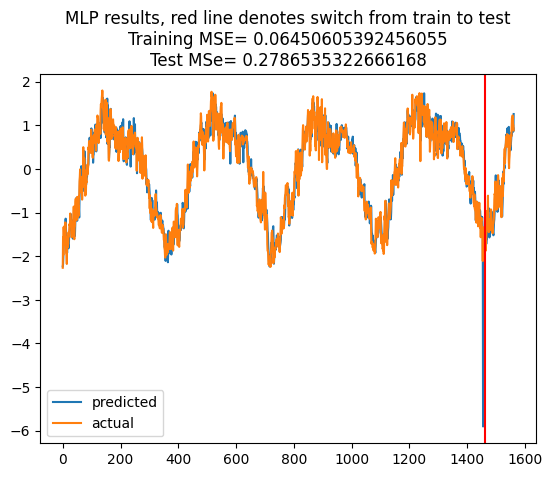

In [20]:
fig,ax = plt.subplots()

ax.plot(predicted,label='predicted')
ax.plot(actual,label="actual")
ax.axvline(x=1462,color='red')
ax.set_title(f'MLP results, red line denotes switch from train to test\n{trainres}\n{testres}')
ax.legend()

# Algorithm 2: A 1-D CNN

## Preprocess the data
The 2D CNN neeed to know the height and width of images in order to optimise its inner loops
- look at my code from week 2 for an example
- or [Keras.layers.Conv2d api](https://keras.io/api/layers/convolution_layers/convolution2d/)

Similarly the 1D CNN layer needs to have a fixed size number of timesteps (sequences) to work with
- not necessarily the same as the size of the filters (usually bigger)
- but  it needs to know the size of the loop to run it's filters over


So we can re-use the code we wrote to create the datasets 
- we'll change  the length of sequences we convolve over to 20 so convolution has something to work with
- but we should consider the number of timesteps in a sequence as a hyper-paramter to optimise


In [55]:
window_size=20
batchsize=32
num_features=4

cnn_train = Keras.utils.timeseries_dataset_from_array(
    train,
    sequence_length=window_size, 
    targets=train[window_size:,0],
    #shuffle=True,
    batch_size=1
    ).batch(batchsize,drop_remainder=True)

cnn_test = Keras.utils.timeseries_dataset_from_array(
    test,
    sequence_length=window_size, 
    targets=test[window_size:,0],
    #shuffle=True,
    batch_size=1
    ).batch(batchsize,drop_remainder=True)

In [63]:
#print(list (cnn_test.take(1)))

## Now specify the 1D CNN architecture
- Let's see how we get on with kernel size 3 (days) : another hyper-parameter to be tuned
- we also need to specify the input shape which is. 
- uncommenting and running the cell above reveals this is (batch_size,1,sequence_length, num_features)  
   

In [68]:
oneD_cnn = Keras.Sequential(
                           [ Keras.layers.Conv1D(filters=32,
                                 kernel_size=5,
                                 batch_input_shape=(batchsize,1,window_size,num_features),
                                 activation='relu'
                                 ),
                            Keras.layers.Flatten(),
 #                           Keras.layers.Dense(10,activation='relu'),
                            Keras.layers.Dense(1,activation='linear')]
            )
oneD_cnn.compile(optimizer='adam', loss='mse')
oneD_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (32, 1, 16, 32)           672       
                                                                 
 flatten_10 (Flatten)        (32, 512)                 0         
                                                                 
 dense_15 (Dense)            (32, 1)                   513       
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [69]:
history= oneD_cnn.fit(cnn_train, epochs=25)

Epoch 1/25
22/45 [=============>................] - ETA: 0s - loss: 0.5727

2023-03-15 02:47:59.989525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 0s 5ms/step - loss: 0.3918
Epoch 2/25
45/45 [==============================] - 0s 5ms/step - loss: 0.1654
Epoch 3/25
45/45 [==============================] - 0s 4ms/step - loss: 0.1337
Epoch 4/25
45/45 [==============================] - 0s 4ms/step - loss: 0.1185
Epoch 5/25
45/45 [==============================] - 0s 4ms/step - loss: 0.1083
Epoch 6/25
45/45 [==============================] - 0s 4ms/step - loss: 0.1004
Epoch 7/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0944
Epoch 8/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0897
Epoch 9/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0856
Epoch 10/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0814
Epoch 11/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0780
Epoch 12/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0751
Epoch 13/25
45/45 [==============================] - 0s 5ms/

In [70]:
trainres=f'Training MSE= {oneD_cnn.evaluate(cnn_train)}'
testres=f'Test MSe= {oneD_cnn.evaluate(cnn_test)}'#.batch(batch_size=1))}'


y_train = np.concatenate([y for x, y in cnn_train], axis=0)
y_train_pred= oneD_cnn.predict(cnn_train).reshape(y_train.shape[0])


y_test = np.concatenate([y for x, y in cnn_test], axis=0)
y_test_pred= oneD_cnn.predict(cnn_test).reshape(y_test.shape[0])

actual = np.vstack((y_train,y_test))
predicted= np.concatenate((y_train_pred, y_test_pred))

1/2 [==============>...............] - ETA: 0s - loss: 0.4232

2023-03-15 02:48:07.992625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 3ms/step


2023-03-15 02:48:08.277327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


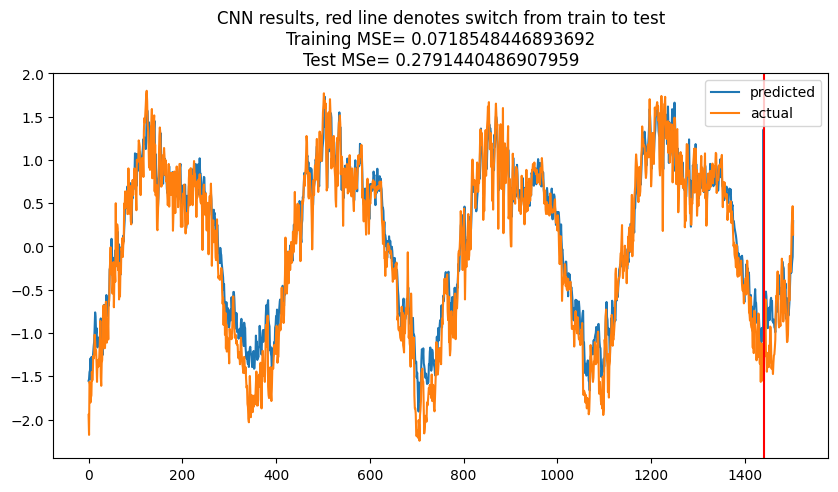

In [71]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(predicted,label='predicted')
ax.plot(actual,label="actual")
ax.axvline(x=y_train.shape[0],color='red')
ax.set_title(f'CNN results, red line denotes switch from train to test\n{trainres}\n{testres}')
ax.legend()

# Algorithm 3 LSTM Network
- Same way of creating the dataset, 
- this time we only have batchsize 1 which is slower, 
  but makes sense if we also preserve state between timesteps
- getting the sequence length right woulfd be a good start for experimentation

In [83]:
batchsize=1
window_size=7
lstm_train=  Keras.utils.timeseries_dataset_from_array(
    train,
    sequence_length=window_size, 
    targets=train[window_size:,0],
    shuffle=False,
    batch_size=1
    )#.batch(batch_size=batchsize,drop_remainder=True)
lstm_test=  Keras.utils.timeseries_dataset_from_array(
    test,
    sequence_length=window_size, 
    targets=test[window_size:,0],
    shuffle=False,
    batch_size=1
    )#.batch(batch_size=batchsize,drop_remainder=True)

In [84]:
print( list(lstm_test.take(1)))

[(<tf.Tensor: shape=(1, 7, 4), dtype=float64, numpy=
array([[[  -1.30452123,    1.49713608,   -0.89006431, -121.59778011],
        [  -0.95234302,    0.98130535,   -0.85695799,    1.29360441],
        [  -1.14142096,    1.25968104,   -0.61085889,    1.30072153],
        [  -0.9251158 ,    0.55346844,   -0.49499738,    0.96336984],
        [  -0.96746925,    0.84543151,   -0.76802119,    0.78828859],
        [  -0.84095892,    1.1063334 ,    0.41219127,    0.46025386],
        [  -1.4685258 ,    2.09149411,    0.71040092,    0.40930172]]])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.33567366])>)]


In [85]:
lstmnet=Keras.Sequential(
        [Keras.layers.LSTM(units=32,
                           stateful=True,
                           batch_input_shape=(batchsize,window_size,num_features)),
#         Keras.layers.Dense(10,activation='relu'),
         Keras.layers.Dense(1)]
)

lstmnet.compile(optimizer='adam',loss='mse')



In [86]:
#dataset=train_series
history=lstmnet.fit(lstm_train,epochs=10)

Epoch 1/10


2023-03-15 02:52:11.677618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 02:52:11.745923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 02:52:11.816622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1455/1455 [==============================] - 12s 8ms/step - loss: 0.1087
Epoch 2/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0761
Epoch 3/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0639
Epoch 4/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0566
Epoch 5/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0524
Epoch 6/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0503
Epoch 7/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0491
Epoch 8/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0483
Epoch 9/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0477
Epoch 10/10
1455/1455 [==============================] - 12s 8ms/step - loss: 0.0471


In [87]:
trainres=f'Training MSE= {lstmnet.evaluate(lstm_train)}'
testres=f'Test MSe= {lstmnet.evaluate(lstm_test)}'#.batch(batch_size=1))}'

  22/1455 [..............................] - ETA: 7s - loss: 0.0955 

2023-03-15 02:54:36.213494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 02:54:36.244113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 1s 4ms/step - loss: 0.0635


In [88]:
y_train = np.concatenate([y for x, y in lstm_train], axis=0)
y_train_pred= lstmnet.predict(lstm_train).reshape(y_train.shape[0])


y_test = np.concatenate([y for x, y in lstm_test], axis=0)
y_test_pred= lstmnet.predict(lstm_test).reshape(y_test.shape[0])

print(y_train.shape,y_test.shape)
actual = np.concatenate((y_train,y_test),axis=0)
predicted= np.concatenate((y_train_pred, y_test_pred))

  34/1455 [..............................] - ETA: 4s

2023-03-15 02:54:44.630915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 02:54:44.656696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 0s 3ms/step
(1455,) (107,)


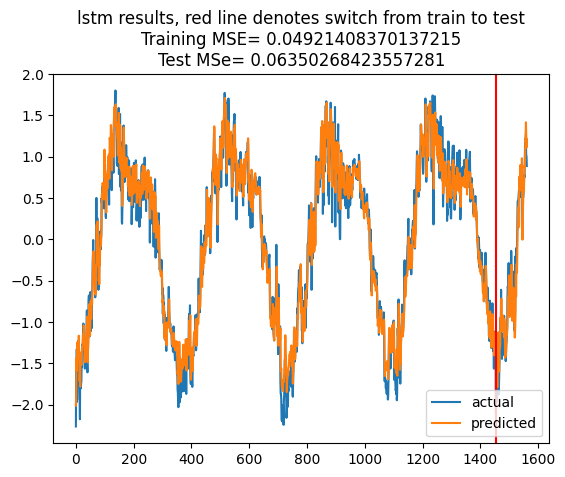

In [89]:
fig,ax = plt.subplots()
ax.plot(actual,label="actual")
ax.plot(predicted,label='predicted')
ax.axvline(x=y_train.shape[0],color='red')
ax.set_title(f'lstm results, red line denotes switch from train to test\n{trainres}\n{testres}')
ax.legend()